<a href="https://colab.research.google.com/github/mklingebiel/active_inference/blob/main/Simulating_active_inference_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating Active inference from scratch

In this notebook, we will continue on from the last notebook to build a fully fledged active inference agent capable of performing inference and planning using Active Inference in the simple grid-world environment. We will also begin to use some aspects of `pymdp`, although this will mostly be helpful functions for building and sampling from discrete distributions while we will implement the core functionality of the agent ourselves.


First, we simply start out by defining our generative model as we did last time.

## Pip install `pymdp` library

In [ ]:
! pip install inferactively-pymdp

### After you `pip install` the package, you will most likely see the following warning message, following all the normal installation notifications:

<img src="https://drive.google.com/uc?export=view&id=1Cdo_bz7lUQ51o2q0qDQNHm8YG0d8Zk4O" width="650" height="120" />



---


### Don't be alarmed; simply click `RESTART RUNTIME`, click `Yes` in response to the following warning window that asks you whether you're okay clearing all local variables:

<img src="https://drive.google.com/uc?export=view&id=1McQd1B6myE22cV3tM_EXOvKW1QhsJOv4" width="650" height="150" />


### After clicking `Yes` you don't need to re-run anything - just continue running the notebook below.



---



## Imports
### Note:  we use the `spm_log_single` helper function from the `maths` sub-library of pymdp. This is a numerically stable version of np.log() based on the function from MATLAB's `SPM` library, called `spm_log.m` 

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

from pymdp import maths, utils
from pymdp.maths import spm_log_single as log_stable # @NOTE:
from pymdp import control

## Plotting

In [ ]:
state_mapping = {0: (0,0), 1: (1,0), 2: (2,0), 3: (0,1), 4: (1,1), 5:(2,1), 6: (0,2), 7:(1,2), 8:(2,2)}

A = np.eye(9)
def plot_beliefs(Qs, title=""):
    #values = Qs.values[:, 0]
    plt.grid(zorder=0)
    plt.bar(range(Qs.shape[0]), Qs, color='r', zorder=3)
    plt.xticks(range(Qs.shape[0]))
    plt.title(title)
    plt.show()
    
labels = [state_mapping[i] for i in range(A.shape[1])]
def plot_likelihood(A):
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(A, xticklabels = labels, yticklabels = labels, cbar = False)
    plt.title("Likelihood distribution (A)")
    plt.show()
    
def plot_empirical_prior(B):
    fig, axes = plt.subplots(3,2, figsize=(8, 10))
    actions = ['UP', 'RIGHT', 'DOWN', 'LEFT', 'STAY']
    count = 0
    for i in range(3):
        for j in range(2):
            if count >= 5:
                break
                
            g = sns.heatmap(B[:,:,count], cmap="OrRd", linewidth=2.5, cbar=False, ax=axes[i,j])

            g.set_title(actions[count])
            count += 1
    fig.delaxes(axes.flatten()[5])
    plt.tight_layout()
    plt.show()
    
def plot_transition(B):
    fig, axes = plt.subplots(2,3, figsize = (15,8))
    a = list(actions.keys())
    count = 0
    for i in range(dim-1):
        for j in range(dim):
            if count >= 5:
                break 
            g = sns.heatmap(B[:,:,count], cmap = "OrRd", linewidth = 2.5, cbar = False, ax = axes[i,j], xticklabels=labels, yticklabels=labels)
            g.set_title(a[count])
            count +=1 
    fig.delaxes(axes.flatten()[5])
    plt.tight_layout()
    plt.show()

## Generative model

Here, we setup our generative model which is the same as in the last notebook. This is formed of a likelihood distribution $P(o_t|s_t)$, denoted `A`, and a empirical prior (transition) distribution $P(s_t|s_{t-1},a_{t-1})$, denoted `B`.

Since this was covered in more detail in the previous tutorial, we quickly skip over the details here


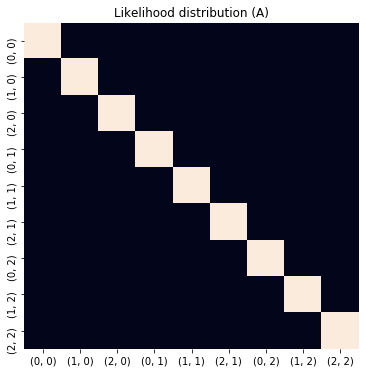

In [ ]:
# A matrix
A = np.eye(9)
plot_likelihood(A)

In [ ]:
#noisy observation
A_noise= np.diag(np.ones(9),0) + np.diag(np.ones(8),1) + np.diag(np.ones(8),-1)
plot_likelihood(A_noise)

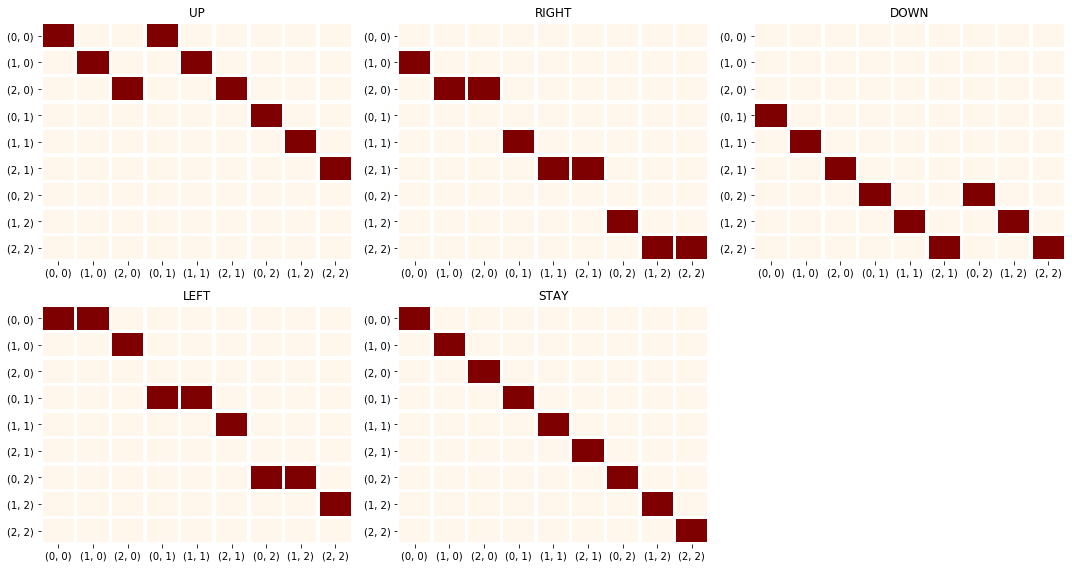

In [ ]:
# construct B matrix

P = {}
dim = 3
actions = {'UP':0, 'RIGHT':1, 'DOWN':2, 'LEFT':3, 'STAY':4}

for state_index, xy_coordinates in state_mapping.items():
    P[state_index] = {a : [] for a in range(len(actions))}
    x, y = xy_coordinates

    '''if your y-coordinate is all the way at the top (i.e. y == 0), you stay in the same place -- otherwise you move one upwards (achieved by subtracting 3 from your linear state index'''
    P[state_index][actions['UP']] = state_index if y == 0 else state_index - dim 

    '''f your x-coordinate is all the way to the right (i.e. x == 2), you stay in the same place -- otherwise you move one to the right (achieved by adding 1 to your linear state index)'''
    P[state_index][actions["RIGHT"]] = state_index if x == (dim -1) else state_index+1 

    '''if your y-coordinate is all the way at the bottom (i.e. y == 2), you stay in the same place -- otherwise you move one down (achieved by adding 3 to your linear state index)'''
    P[state_index][actions['DOWN']] = state_index if y == (dim -1) else state_index + dim 

    ''' if your x-coordinate is all the way at the left (i.e. x == 0), you stay at the same place -- otherwise, you move one to the left (achieved by subtracting 1 from your linear state index)'''
    P[state_index][actions['LEFT']] = state_index if x == 0 else state_index -1 

    ''' Stay in the same place (self explanatory) '''
    P[state_index][actions['STAY']] = state_index


num_states = 9
B = np.zeros([num_states, num_states, len(actions)])
for s in range(num_states):
    for a in range(len(actions)):
        ns = int(P[s][a])
        B[ns, s, a] = 1

plot_transition(B)

# Create Environment Class

To make things simple we will parcel up the $A$ and $B$ matrices into a class which represents the environment. The environment has two functions `step` which when given an action will update the environment a single step and `reset` which resets the environment back to its initial condition. The API of our simple environment class is similar to the `Env` base class used by `pymdp`, although the `pymdp` version has many more features than we use here.

In [ ]:
class GridWorldEnv():
    
    def __init__(self,A,B):
        self.A = deepcopy(A)
        self.B = deepcopy(B)
        print("B:", B.shape)
        self.state = np.zeros(9)
        # start at state 3
        self.state[2] = 1
    
    def step(self,a):
        self.state = np.dot(self.B[:,:,a], self.state)
        obs = utils.sample(np.dot(self.A, self.state))
        return obs

    def reset(self):
        self.state =np.zeros(9)
        self.state[2] =1 
        obs = utils.sample(np.dot(self.A, self.state))
        return obs
    
env = GridWorldEnv(A,B)

B: (9, 9, 5)


# Inference

Now that we have the generative model setup, we turn to the behaviour of the active inference agent itself. To recap, we assume that this agent receives observations from the environment and can emit actions. Moreover, we assume that this agent has some kind of goal or preferences over the state of the environment it wants to create, and will choose actions in order to increase the probability of observing itself in its preferred state. For the time being, we will not deal with the problem of action selection but only with inference.

The agent receives observations $o_t$ from the environment but does not naturally know the environments true state $x_t$. Thus, the agent must *infer* this state by computing the posterior distribution $p(x_t | o_t)$. It can do this by Bayesian inference using Bayes rule but, as we discussed last time, explicitly computing Bayes rule is often intractable because the marginal likelihood requires the averaging over an infinite number of hypotheses. We therefore need some other way to compute or approximate this posterior. Active inference assumes that this posterior can be approximated through a family of methods called *variational inference* which only approximate the posterior, but are fast and computationally efficient.

# Variational Inference


Variational inference is a set of inference methods which can rapidly and efficiently compute *approximate* posteriors for Bayesian inference problems. The key idea behind variational inference is that instead of trying to compute the true posterior $p(x_t | o_t)$ which may be extremely complex, is that we instead optimize an *approximate posterior*. Specifically, we will define another distribution $q(x_t ; \phi)$ which has some parameters $\phi$ which we then optimize so as to make $q(x_t ; \phi)$ as close as possible to the true distribution. Typically, we choose this $q$ distribution to be some simple distribution which is easy to work with mathematically. If the process works, then we can get the $q$ distribution very close to the true posterior, and as such get a good estimate of the posterior without ever explicitly computing it using Bayes rule. 

Mathematically, we can do this by setting up an optimization problem. We have the true posterior $p(x_t | o_t)$, which is unknown, and we have our $q$ distribution which we do know. We then want to optimize the $q$ distribution to make it as *close as possible* to the true posterior $p(x_t | o_t)$. To do this, we first need a way to quantify *how close* two probability distributions are. The way we do this is by using a quantity known as the *Kullback-Leibler (KL) divergence*. This is a metric derived from information theory which lets us quantify the distance (in bits) of two distributions. The KL divergence between two distributions $q(x)$ and $p(x)$ is defined as,
$$
\begin{align}
KL[q(x) || p(x)] = \sum_x q(x) (\ln q(x) - \ln p(x))
\end{align}
$$
Mathematically it can be thought of as the average of the difference of the logarithms of the probabilities assigned by $q$ and $p$ to the states $x$. The KL divergence is smallest when $q(x) = p(x)$ when it is equal to 0, and can grow to be infinitely large which happens wherever $q(x)$ assigns a nonzero probability but $p(x)$ doesn't. In code, we can compute the KL divergence as:


In [ ]:
def KL_divergence(q,p):
    return np.sum(q * (log_stable(q) - log_stable(p)))

Now that we know about the KL divergence, we can express our variational problem of making our approximate posterior $q(x_t ; \varphi)$ as close as possible to the true posterior as simply minimizing the KL divergence between the two distributions. That is, we can define the optimal approximate distribution as,
$$
\begin{align}
q^*(x_t ; \varphi) = \operatorname{argmin}_{\varphi} \, KL[q(x_t ; \varphi) || p(x_t | o_t)]
\end{align}
$$

And then simply try to optimize this objective so as to find the setting of the variational parameters $\varphi$ that make $q(x_t ; \varphi)$ as close to $p(x_t |o_t)$ as possible. The trouble with this is that our objective actually explicitly contains the true posterior in it and so, since we can't conpute the true posterior, we can't compute this objective either -- so we are stuck!

Variational inference provides a clever way to get around this problem by instead minimizing an *upper bound* on this divergence called the *variational free energy*. Importantly this bound is computable so we can actually optimize it and moreover since it is an upper bound, if we minimize it, we can make $q$ as close as possible to the real bound, thus still managing to obtain a good approximate posterior distribution. Deriving the variational free energy is very simple, we first take our initial objective and apply Bayes rule to the true posterior, and then take out the marginal likelihood term separately
<!-- $$
\begin{align}
 KL[q(x_t | o_t) || p(x_t |  o_t)] &= KL[q(x_t | o_t) || \frac{p(o_t,x_t)}{p(o_t)}] \\
 &= KL[q(x_t | o_t) || p(o_t, x_t)] + \sum_x q(x_t | o_t) \ln p(o_t) \\
 &= KL[q(x_t | o_t) || p(o_t, x_t)] +  \ln p(o_t) 
\end{align}
$$ -->

$$
\begin{align}
 KL[q(x_t ; \varphi) || p(x_t |  o_t)] &= KL[q(x_t ; \varphi) || \frac{p(o_t,x_t)}{p(o_t)}] \\
 &= KL[q(x_t ; \varphi) || p(o_t, x_t)] + \sum_x q(x_t ; \varphi) \ln p(o_t) \\
 &= KL[q(x_t ; \varphi) || p(o_t, x_t)] +  \ln p(o_t) 
\end{align}
$$


Where in the final line we have used the fact that the sum is over a different variable than the distribution, and the sum of a probability distribution is $1$ -- i.e $\sum_x q(x_t ; \varphi) \ln p(o_t) = \ln p(o_t) * \sum_x q(x_t ; \varphi)$ and $\sum_x q(x_t ; \varphi) = 1$. Specifically, since $ \ln p(o_t)$ is the log of a probability distribution it is always negative, since the probability of a state is always between 0 and 1. This means that we know that this term we have devised $KL[q(x_t ; \varphi) || p(o_t, x_t)]$ is always necessarily greater than our original divergence between the approximate posterior and the true posterior, so it is an *upper bound*. We call this term the *variational free energy* and denote it by $\mathcal{F}$.
$$
\begin{align}
\mathcal{F} = KL[q(x_t ; \varphi) || p(o_t, x_t)]
\end{align}
$$

The free energy here is simply the divergence between the approximate posterior and the *generative model* of the agent. Since we know both the approximate posterior (as we defined it in the first place!) and the generative model, then both terms of this divergence are computable. We thus have our algorithm to approximate the posterior! Since the free energy is an upper bound, if we minimize the free energy, we also implicitly minimize the true divergence between the true and approximate posteriors, which will force the approximate posterior to be close to the true posterior and thus a good approximation! Moreover, since we can compute the free energy, we can actually perform this optimization! 

In many cases, we typically perform variational inference by taking the gradients of the free energy with respect to the variational parameteres $\varphi$ and then doing gradient descent on the parameters $\varphi$ that define $q(x_t ; \varphi)$. However, when the distributions are discrete (i.e. Categorical distributions), the parameters of the approximate distribution are simply the probability values for each state (the elements of the vector $q(x)$. For some simple generative models (e.g. the grid-world described here), we can actually solve this optimization problem directly to obtain $q(x)$ in a single step, instead of as a gradient descent.

# Directly solving variational inference in the case of a simple discrete model

To recap, remember that we have turned the problem of computing the posterior distribution $p(x_t | o_t)$ into that of minimizing the variational free energy: $\mathcal{F} = KL[q(x_t) || p(o_t, x_t)]$ with respect to an approximate posterior distribution $q(x_t)$. From now on, we will leave out the variational parameters $\varphi$ when referring to $q(x_t)$, since we are dealing with a single Categorical distribution $q(x_t)$ whose vector elements are identical to the variational parameters, i.e. $\forall_{i} \varphi_i = q(x_t = i)$.

The optimal distribution is simply that particular $q^*(x_t)$ that minimizes the KL divergence. Now, remember from high-school calculus that we can explicitly compute the minimum of a function by taking its derivative and setting it to 0 (i.e. at the minimum the first derivative of the function is 0) (if you don't remember this from calculus, trust me on this). This means that to solve this problem all we need to do is take the derivative of the free energy and set it to 0 and rearrange. First, let's write out the free energy explicitly.

<!-- $$
\begin{align}
\mathcal{F} &= KL[q(x_t | o_t) || p(o_t, x_t)] \\
&= \sum_x q(x_t | o_t) (\ln q(x_t | o_t) - \ln p(o_t,x_t))
\end{align}
$$ -->

$$
\begin{align}
\mathcal{F} &= KL[q(x_t) || p(o_t, x_t)] \\
&= \sum_x q(x_t)(\ln q(x_t) - \ln p(o_t,x_t))
\end{align}
$$
If we then split the generative model up into a likelihood and a prior, we can write it as,

$$
\begin{align}
\mathcal{F} = \sum_x q(x_t) \big[ \ln q(x_t) - \ln p(o_t | x_t)  - \ln p(x_t) \big]
\end{align}
$$
Recall that we have explicitly defined the observation and transition likelihood distributions as the $\textbf{A}$ and $\textbf{B}$ matrices, which play the role of the likelihood and prior distributions, respectively. In particular, we can define the prior over the current timestep $p(x_t)$ to be the "expected prior", given the beliefs about the state at the last timesep $q(x_{t-1})$ the beliefs about the transition dynamics and the past action, i.e.:

$$
\begin{align}
p(x_t) = \mathcal{E}_{q(x_{t-1})}\big[p(x_t | x_{t-1}, a_t) \big]
\end{align}
$$

which can be expressed as a simple matrix vector product

$$
\begin{align}
p(x_t) = \textbf{B}_{a_t}q(x_{t-1})
\end{align}
$$

where $\textbf{B}_{a_t}$ is the component of the $\textbf{B}$ matrix that is conditioned on action $a_t$. In other words, for this simple Markovian model, we assume that "yesterday's posterior is today's prior." For simplicity, we refer to this entire prior term as $\textbf{B}$ below, i.e. we temporarily define $\textbf{B} \equiv \textbf{B}_{a_t}q(x_{t-1})$.

As mentioned above, the posterior beliefs $q(x_t)$ are a vector of probabilities (the variational parameters) which we denote $\textbf{q} = [q_1, q_2, q_3 \dots]$. With this all defined, we can write out the free energy as,

$$
\begin{align}
\mathcal{F} = \sum_x \textbf{q} * \big[ \ln \textbf{q} - \ln \textbf{A}  - \ln \textbf{B} \big]
\end{align}
$$


And for fun, we can explicitly compute it in code:

In [ ]:
def compute_free_energy(q,A, B):
    return np.sum(q * (log_stable(q) - log_stable(A) - log_stable(B)))

Then, all we need to do is take the derivative of the free energy with respect to the approximate posterior distribution $\textbf{q}$ as follows,
$$
\begin{align}
\frac{\partial \mathcal{F}}{\partial \textbf{q}} = \ln \textbf{q} - \ln \textbf{A} - \ln \textbf{B} + \textbf{1}
\end{align}
$$

Where $\textbf{1}$ is just a vector of ones of equal length to $\textbf{q}$ and comes from the $q \frac{\partial \ln q}{\partial q} = q * \frac{1}{q} = 1$. Thus, if we set this derivative to 0 and rearrange, we can get,
$$
\begin{align}
0 &= \ln \textbf{q} - \ln \textbf{A} - \ln \textbf{B} + \textbf{1} \\
\ln \textbf{q} &= \ln \textbf{A} + \ln \textbf{B} - \textbf{1} \\
&\implies \textbf{q}^* = \sigma(\ln \textbf{A} + \ln \textbf{B})
\end{align}
$$

Where $\sigma$ is a softmax function $\sigma(x) = \frac{e^x}{\sum_x e^x}$ which ensures that the resulting probability distribution is normalized. This expression lets us compute the optimal approximate posterior instantly as a straightforward function of the current observation $o_t$, $\textbf{A}$, and $\textbf{B}$. We can thus quickly right the code for inference:

In [ ]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def perform_inference(likelihood, prior):
    return softmax(log_stable(likelihood) + log_stable(prior))

Note that the likelihood term is not the entire $\textbf{A}$ matrix, but just the 'row' of the $\textbf{A}$ matrix corresponding to the current observation, i.e. $P(o_t = o \mid x_t)$. 

Inference for simple discrete state-space models like these is therefore very simple. All we need to do is have some initial set of beliefs $\textbf{q}_0$ and then update them according to these rules for every observation we get, using the $\textbf{A}$, $\textbf{B}$, the past action $a_t$ and the past posterior $q(x_{t-1})$ to provide the likelihood and prior terms.

# Planning through Active Inference

So far we just have an agent that can perform perform inference in the discrete state space, but inference by itself isn't really that useful. Instead what we really want to do is *planning*. That is, the agent needs to be able to figure out how to emit a series of actions which will take it to a certain goal state. A key part of Active Inference is that this process of planning, or more broadly action selection, can also be solved as a process of variational inference. This is why it is called *Active* Inference, after all. 

<!-- However, when starting to think about this, it is not immediately obvious how to turn planning into an inference problem. What are the hypotheses? What are the observations? To turn the problem of planning into an inference problem, we need to introduce two additional concepts. The first is the idea of a *goal state*. To make planning useful, the agent has to *want something*. This is different from just performing objective inference about the state of the world in which there is no goal except to infer correctly. In Active Inference we define the goal state as a separate goal vector denoted $\textbf{C}$. When performing planning we then modify the generative model of the agent so that it no longer reflects the true distribution of observations in the environment, but rather includes the goal vector. We denote this new generative model $\tilde{p}(o_t, x_t) = p(o_t | x_t)\tilde{p}(x_t)$ where we use $\tilde{p}$ to say that this distribution is not a true distribution describing the agents model of the world, but is instead a *desired distribution*. Here, we set the desired distribution to be over the state of the environment $x_t$ such that $\tilde{p}(x_t) = \textbf{C}$. -->

However, when starting to think about this, it is not immediately obvious how to turn planning into an inference problem. What are the hypotheses? What are the observations? To turn the problem of planning into an inference problem, we need to introduce two additional concepts. The first is the idea of a *preferred observations*. To make planning useful, the agent has to *want something*. This is different from just performing objective inference about the state of the world in which there is no goal except to infer correctly. In Active Inference, we define the preferred observations as a separate goal vector denoted $\textbf{C}$. When performing planning we then modify the generative model of the agent so that it no longer reflects the true distribution of observations in the environment, but rather includes the goal vector, which is a *prior over observations*. We denote this new generative model $\tilde{p}(o_t, x_t) = p(x_t | o_t)\tilde{p}(o_t)$ where we use $\tilde{p}$ to say that this distribution is not a true distribution describing the agent's model of the world, but is instead a *preference distribution*. Here, we set the preference distribution to be over the state of the environment $o_t$ such that $\tilde{p}(o_t) = \textbf{C}$.

By changing the generative model in this way, we have effectively changed the inference problem from: *infer the most likely states and actions given the true generative model of the world* to *infer the most likely states and actions given a false model of the world, in which I achieve my goals*. Perhaps more intuitively, we can think of this inference problem as answering the question: *Given that I have achieved my goals, what actions must have I taken to get there?*.

The second thing we need to do to perform planning is to also extend the inference problem to *actions in the future*, since these are the fundamental things that the agent controls which it can use to adjust the environment. We call a sequence of future actions from now (time $t$) until some set future time $T$ a *policy* and denote it $\pi = [a_t, a_{t+1}, a_{t+2} \dots a_T]$. The goal is then to infer the optimal policy $\pi^*$ given the preferences $\textbf{C}$. 

However here there is a problem. Typically we would perform variational inference to solve this inference problem, but the variational free energy is not defined over future trajectories of observations, which are not yet known. Instead, we define a new objective which can handle this -- the *Expected Free Energy (EFE)*, which is defined over policies and which we denote as $\mathcal{G}(\pi)$. We define the EFE for a particular timepoint $\tau$ and policy $\pi$ as:

$$
\begin{align}
\mathcal{G}(\pi)_{\tau} = \sum_{o_{\tau}, x_{\tau}} q(x_{\tau} | \pi)q(o_{\tau} | \pi) \big[ \ln q(x_{\tau} | \pi) - \ln \tilde{p}(o_{\tau}, x_{\tau}) \big]
\end{align}
$$

The expected free energy is defined for a single time-step of a trajectory *in the future*, i.e. prior to receiving any observations. The key difference between the standard variational free energy and the expected free energy is that the expected free energy also averages over the *expected observations* $q(o_{\tau} | pi)$ and *expected states* $q(x_{\tau} | \pi)$, where the expectations are conditioned on some policy $\pi$. This is necessary because with the expected free energy, we are evaluating possible future trajectories without a given observation, unlike the variational free energy where we can assume that we have already received the observation.

To get an intuitive handle on what the expected free energy *means* we can decompose it into two more intuitive quantities.

$$
\begin{align}
\mathcal{G}(\pi)_{\tau}&= \sum_{o_{\tau}, x_{\tau}} q(x_{\tau} | \pi)q(o_{\tau} | \pi) \big[ \ln q(x_{\tau} | \pi) - \ln \tilde{p}(o_{\tau}, x_{\tau}) \big] \\
&= -\underbrace{\sum_{o_{\tau}, x_{\tau}} q(x_{\tau} | \pi)q(o_{\tau} | \pi) \big[ \ln p(o_{\tau} | x_{\tau}) \big]}_{\text{Uncertainty}} + \underbrace{KL[q(x_{\tau} | \pi) || \tilde{p}(x_{\tau}) ]}_{\text{Divergence}}
\end{align}
$$

The first term is called *expected uncertainty* or sometimes *novelty* and represents essentially the spread of the observations expected in the future. Since we are choosing actions that *minimize* the whole quantity, we want to take actions that *maximize* novelty. We can think of this as a bonus to aid exploration since active inference agents will preferentially pursue resolveable uncertainty. The second term is the *divergence* term which is the KL divergence between the states expected under a given policy (also known as the posterior predictive density $q(x_\tau | \pi)$) and the goal distribution of the generative model, $\tilde{p}(x)$. This term scores how far away (in an informational sense) the agent expects it will be from the goal, if it were to pursue that policy. Since we are minimizing the expected free energy this term is positive and so is also minimized -- that is by minimizing the expected free energy, we are trying to choose trajectories which will bring the expected states in the future close to the desired states.

Now that we have the expected free energy to score possible trajectories, we now need to infer the optimal policy. A simple approach (which can be derived explicitly although it is somewhat complex) is to say that the posterior probability of a policy is proportional to the (exponentiated) sum of the expected free energy accumulated along the trajectory through the environment created by that policy. While this sounds complex, mathematically we can express it very simply as,
$$
\begin{align}
q(\pi) = \sigma( \sum_{\tau}^T \mathcal{G}(\pi)_{\tau})
\end{align}
$$
<!-- We can then choose which policy we implement for the next timestep by just sampling a policy from $q(\pi)$ and then emitting the first action of that policy. -->
We can then choose which action we choose for the next timestep by computing the marginal probability of each action $P(a)$, given the posterior over actions $q(\pi)$ and some mapping between policies and actions $P(a | \pi)$:

$$
\begin{align}
P(a) = \sum_{\pi}P(a | \pi)q(\pi)
\end{align}
$$

We can sample from this distribution over actions to choose our action for the next timestep.

In our simple grid world environment, policies are identical to actions since we are only planning ahead 1-step in the future, so $\forall_{i} P(a = i | \pi = i) = 1$, which implies $P(a) == q(\pi)$.

While all this may seem exceptionally long and complex, it results in an algorithm which is actually remarkably simple. The algorithm is:

1.) There is an agent with a generative model of the environment ($\textbf{A}$ and $\textbf{B}$ matrices), some initial set of approximate posterior beliefs $q(x_t | o_t)$ and a desired state vector $\textbf{C}$. 

2.) The agent receives an observation $o_t$ and computes its posterior beliefs as we did earlier by minimizing the free energy.

3.) The agent now needs to choose what action to make to achieve its goals. It does this by:

 3.1.) First creating a set of potential policies to evaluate.
    
   3.2.) For each policy in this set, use the generative model to simulate the agent's trajectory in the environment *as if* it had emitted the actions prescribed by the policy
    
   3.3.) For each future timestep of each future trajectory, compute the expected free energy of that time-step
    
   3.4.) Sum the expected free energies for each timestep of each trajectory to get a total expected free energy for each possible policy.
    
   3.5.) Use these total expected free energies to compute the posterior distribution $q(\pi)$ as done above.

   3.6 ) Compute the marginal probability of each action, expected under the policies that include them, and then sample from this "action marginal" to generate an action at the current timestep.
    
4.) Execute the sampled action to 'step forward' the environmental dynamics and get a new observation. Go back to step 1.



And that's it! We're done. We have the full algorithm to create an active inference agent. Now all we do is show how to translate this algorithm into code for our specific case.

## Beliefs

First we need to setup an initial belief distribution which we will then update according to the observations we will receive.

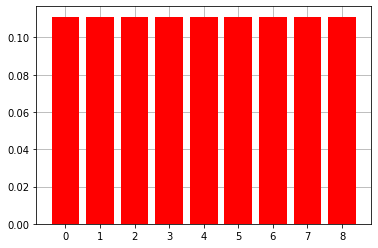

In [ ]:
# setup initial prior beliefs -- uncertain -- completely unknown which state it is in
Qs = np.ones(9) * 1/9
plot_beliefs(Qs)

# Preferences

Now we have to encode the agent's preferences, so that it can learn to go to its reward state. In the current context, the agent wants (i.e. expects) to be in the reward location 7.

(1, 2)
[0. 0. 0. 0. 0. 0. 0. 1. 0.]


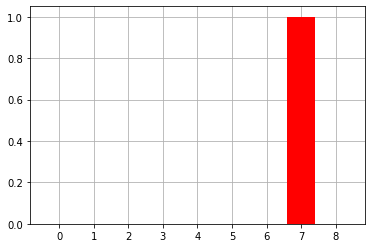

In [ ]:
# C matrix -- desires

REWARD_LOCATION = 7
reward_state = state_mapping[REWARD_LOCATION]
print(reward_state)

C = np.zeros(num_states)
C[REWARD_LOCATION] = 1. 
print(C)
plot_beliefs(C)

The C matrix is a 1x9 matrix, where each value represents the preference to occupy a given state. We will create a one-hot C matrix, so that the agent only has a preference to be in state 7. 

# Implementing the Active Inference Agent

## Evaluate policy 

This helper function we evaluate the negative expected free energy for a given policy $-\mathcal{G}(\pi)$. To do this we need to calculate the cumulative expected free energy for that policy. All that entails is looping through the timesteps of the policy, simulate what the environment would do, using our generative model, evolving posterior beliefs and the actions entailed by the policy, and then compute the expected free energy of our (policy-dependent) expectations about the hidden states and observations.


In [ ]:
def evaluate_policy(policy, Qs, A, B, C):
    # initialize expected free energy at 0
    G = 0

    # loop over policy
    for t in range(len(policy)):

        # get action entailed by the policy at timestep `t`
        u = int(policy[t])

        # work out expected state, given the action
        Qs_pi = B[:,:,u].dot(Qs)

        # work out expected observations, given the action
        Qo_pi = A.dot(Qs_pi)

        # get entropy
        H = - (A * log_stable(A)).sum(axis = 0)

        # get predicted divergence
        # divergence = np.sum(Qo_pi * (log_stable(Qo_pi) - log_stable(C)), axis=0)
        divergence = KL_divergence(Qo_pi, C)
        
        # compute the expected uncertainty or ambiguity 
        uncertainty = H.dot(Qs_pi)

        # increment the expected free energy counter for the policy, using the expected free energy at this timestep
        G += (divergence + uncertainty)

    return -G

## Infer action

This helper function will infer the most likely action. Specifically, it computes steps 3.1 to 3.5 in the active inference algorithm. First, it constructs all possible policies for a given policy length and set of actions. Then it loops through every possible policy and computes the expected free energy of that policy using our previous function, and then computing the policy distribution $q(\pi)$ using the softmax over the expected free energies.

In [ ]:
def infer_action(Qs, A, B, C, n_actions, policies):
    
    # initialize the negative expected free energy
    neg_G = np.zeros(len(policies))

    # loop over every possible policy and compute the EFE of each policy
    for i, policy in enumerate(policies):
        neg_G[i] = evaluate_policy(policy, Qs, A, B, C)

    # get distribution over policies
    Q_pi = maths.softmax(neg_G)

    # initialize probabilites of control states (convert from policies to actions)
    Qu = np.zeros(n_actions)

    # sum probabilites of control states or actions 
    for i, policy in enumerate(policies):
        # control state specified by policy
        u = int(policy[0])
        # add probability of policy
        Qu[u] += Q_pi[i]

    # normalize action marginal
    utils.norm_dist(Qu)

    # sample control from action marginal
    u = utils.sample(Qu)

    return u

## Main loop

Here we simply implement the main loop of the active inference agent interacting with the environment. Specifically, this essentially implements steps 1-5 of the MDP "program" we discussed in notebook 1. Specifically, for each timestep, the agent infers an action, it emits that action to the environment, the environment is updated and returns an observation to the agent. The agent then infers the new state of the environment given that observation.

[0. 0. 0. 0. 0. 1. 0. 0. 0.]


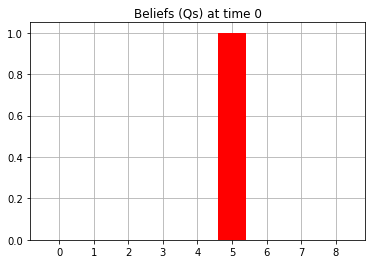

[0. 0. 0. 0. 1. 0. 0. 0. 0.]


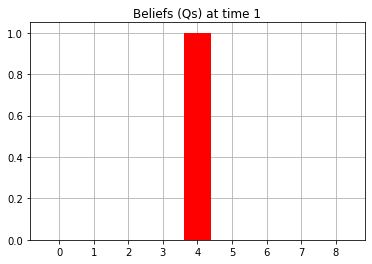

[0. 0. 0. 0. 0. 0. 0. 1. 0.]


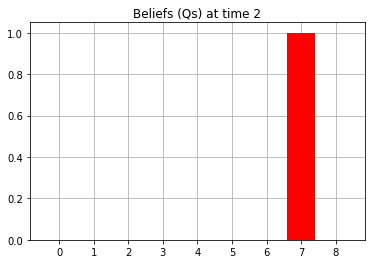

[0. 0. 0. 0. 0. 0. 0. 1. 0.]


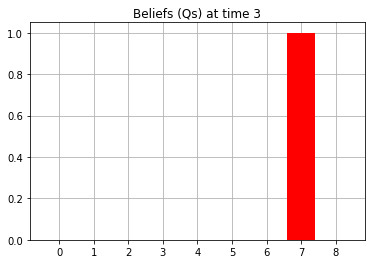

[0. 0. 0. 0. 0. 0. 0. 1. 0.]


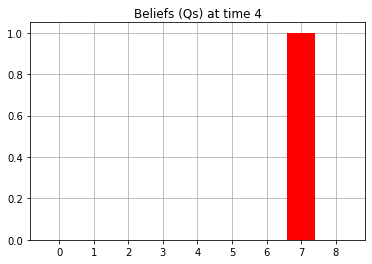

[0. 0. 0. 0. 0. 0. 0. 1. 0.]


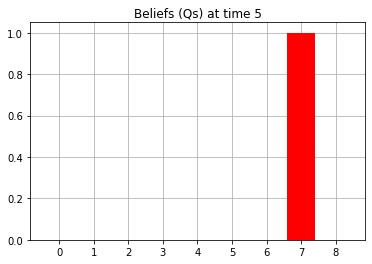

[0. 0. 0. 0. 0. 0. 0. 1. 0.]


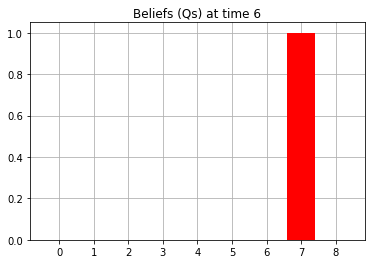

[0. 0. 0. 0. 0. 0. 0. 1. 0.]


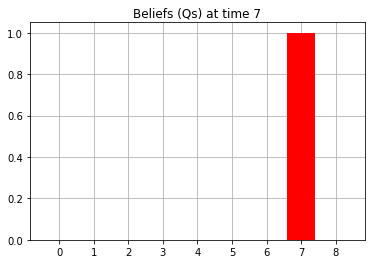

[0. 0. 0. 0. 0. 0. 0. 1. 0.]


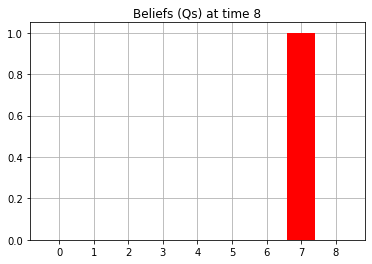

[0. 0. 0. 0. 0. 0. 0. 1. 0.]


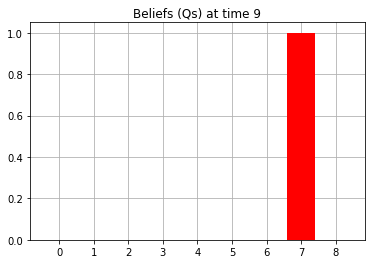

In [ ]:
# number of time steps
T = 10

#n_actions = env.n_control
n_actions = 5

# length of policies we consider
policy_len = 4

# this function generates all possible combinations of policies
policies = control.construct_policies([B.shape[0]], [n_actions], policy_len)

# reset environment
o = env.reset()

# loop over time
for t in range(T):

    # infer which action to take
    a = infer_action(Qs, A, B, C, n_actions, policies)
    
    # perform action in the environment and update the environment
    o = env.step(int(a))
    
    # infer new hidden state (this is the same equation as above but with `pymdp` functions)
    likelihood = A[o,:]
    prior = B[:,:,int(a)].dot(Qs)

    Qs = maths.softmax(log_stable(likelihood) + log_stable(prior))
    
    print(Qs.round(3))
    plot_beliefs(Qs, "Beliefs (Qs) at time {}".format(t))

And that's it! In the last two notebooks, we have implemented a basic active inference agent which can successfully navigate around a 3x3 gridworld using active inference. Moreover, we have implemented this all from scratch using mostly basic numpy functions and not using much of the functionality of `pymdp`. 

Hopefully after going through this you now understand roughly what active inference is and how it works, as well as ideally have some intuitions about how inference as well as policy selection work "under the hood", as well as learnt a lot about Bayesian and specifically variational inference. In the next notebook, we will focus more on the `pymdp` library itself and demonstrate how `pymdp` provides a useful set of abstractions that allows us to easily create active inference agents, as well as perform inference and policy selection in considerably more complex environments than the one described here.

We will discuss the high level structure of the library and show how its possible to replicate these notebooks in a much smaller amount of code using the `pymdp` abstractions.